# Trying to reduce overfitting

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Importing the training / testing data from the downscaled 48 x 64 px images

In [2]:
labels_df = pd.read_pickle('labelsDF')

train_df = pd.read_pickle('trainDF')

# adding the label vector
train_df['Label'] = labels_df[0]

train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,Label
0,59.07,83.23,44.03,11.94,41.71,82.08,124.24,117.76,102.83,109.92,...,58.16,57.54,50.35,18.03,14.44,15.16,14.97,12.08,12.92,0
1,41.52,42.39,43.73,43.34,44.21,44.96,45.24,45.99,46.20,47.54,...,34.81,23.41,43.96,63.65,33.82,11.48,9.97,9.50,41.00,0
2,48.20,48.52,49.00,49.00,50.00,50.42,50.92,51.07,52.40,53.27,...,35.96,23.33,63.14,58.38,35.45,12.48,10.84,9.84,43.95,0
3,30.64,30.68,31.64,32.78,33.00,32.02,31.95,32.00,33.14,35.75,...,35.06,54.45,71.74,66.65,28.95,8.15,6.83,7.69,7.48,0
4,11.93,12.33,14.42,15.07,14.37,11.92,87.94,43.38,24.94,39.85,...,61.12,52.58,27.31,8.26,8.00,7.83,8.09,10.27,9.70,0


### Analyzing if the data is balanced

In [50]:
def count_freqs(labels):
    lbls = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    for i in labels:
        lbls[i] += 1        
    classes = []
    counts = []
    for k, v in lbls.items():
        classes.append(k)
        counts.append(v)
    return classes, counts

In [51]:
classes, counts = count_freqs(train_df['Label'])
print(train_df.shape)
print(classes)
print(counts)

(22424, 3073)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[2489, 2267, 2317, 2346, 2326, 2312, 2325, 2002, 1911, 2129]


#### As this pie chart shows, our image data is reasonably balanced (for the training / labeled data)

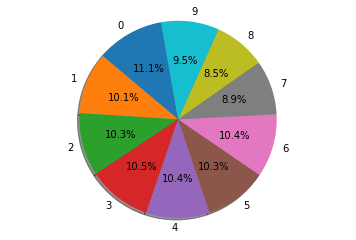

In [52]:
fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=classes, autopct='%1.1f%%', shadow=True, startangle=100)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Now we will shuffle our training data

In [53]:
# shuffling using the shuffle() func from sklearn.utils
shuffled_train_df = shuffle(train_df, random_state = 3)
shuffled_train_df = shuffled_train_df.reset_index(drop = True)
shuffled_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,Label
0,31.93,31.04,32.34,33.64,33.98,32.92,32.03,32.64,34.17,36.90,...,34.32,54.04,70.90,65.68,27.39,8.26,6.92,7.56,7.32,0
1,42.93,42.86,43.99,44.00,43.55,44.20,44.84,44.26,44.15,44.07,...,60.69,59.33,51.65,67.99,30.75,54.38,38.94,10.64,28.71,7
2,47.04,47.39,48.29,48.16,48.16,48.11,48.15,48.16,48.20,48.38,...,71.72,74.74,83.45,112.36,79.78,93.07,107.43,142.88,134.60,5
3,28.03,27.51,27.29,28.44,29.08,28.92,29.24,30.14,30.75,31.09,...,7.92,10.87,40.24,42.31,31.93,35.06,30.81,28.19,24.48,6
4,14.28,14.44,14.94,15.00,15.12,15.44,16.00,16.16,16.00,16.08,...,9.69,11.65,16.17,52.87,28.67,12.64,8.72,7.92,8.11,1


In [55]:
features = [x for x in range(3072)]
X = shuffled_train_df[features]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,31.93,31.04,32.34,33.64,33.98,32.92,32.03,32.64,34.17,36.90,...,26.59,34.32,54.04,70.90,65.68,27.39,8.26,6.92,7.56,7.32
1,42.93,42.86,43.99,44.00,43.55,44.20,44.84,44.26,44.15,44.07,...,55.90,60.69,59.33,51.65,67.99,30.75,54.38,38.94,10.64,28.71
2,47.04,47.39,48.29,48.16,48.16,48.11,48.15,48.16,48.20,48.38,...,71.10,71.72,74.74,83.45,112.36,79.78,93.07,107.43,142.88,134.60
3,28.03,27.51,27.29,28.44,29.08,28.92,29.24,30.14,30.75,31.09,...,21.53,7.92,10.87,40.24,42.31,31.93,35.06,30.81,28.19,24.48
4,14.28,14.44,14.94,15.00,15.12,15.44,16.00,16.16,16.00,16.08,...,34.12,9.69,11.65,16.17,52.87,28.67,12.64,8.72,7.92,8.11


#### Normalizing the feature matrix

In [105]:
X = scale(X)
print(X)

[[-0.46540941 -0.64517063 -0.60040984 ... -0.72835212 -0.76289254
  -0.78576702]
 [ 0.19056931 -0.11070417 -0.04127063 ...  1.07502826 -0.60121127
   0.67000426]
 [ 0.43566682  0.09412942  0.16510693 ...  4.93241497  6.34058448
   7.87671866]
 ...
 [-1.05877198 -1.07654203 -1.04388162 ... -0.33016663 -0.52142052
  -0.64012183]
 [ 0.19593641 -0.09080863 -0.04127063 ... -0.47997899 -0.58126358
   1.67590887]
 [ 1.26637441  2.15331745  0.61769772 ...  0.17221167 -0.07627209
   0.10239638]]


In [106]:
y = shuffled_train_df['Label']
y.head()

0    0
1    7
2    5
3    6
4    1
Name: Label, dtype: int64

## Because we only have the "training" data labeled, I will be splitting it in half
The first half will be used to train/test the model, and the other half will be used as "unseen" data to test our model and evaluiate its performance and generalization

### Here, we will only be using 1/2 of the images to train/test our model, around 10,000 images

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=.50)

#### Now we create the data frame that we will be using to train/test our model, leaving the other half as "unseen", labeled data

In [118]:
training_data_df = pd.DataFrame(X_train)
training_data_df['Label'] = np.array(y_train)
training_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,Label
0,0.302086,-0.044687,0.001445,0.118197,0.133229,-0.010347,-0.283038,-0.286179,-0.245197,-0.202165,...,1.149360,0.857608,-0.136970,0.147016,0.545918,2.603815,1.973339,1.395132,2.478999,4
1,-0.262652,1.352522,0.273575,-1.006202,-1.068265,-0.060194,1.134285,1.447663,1.365340,1.087757,...,-0.157643,-0.273674,-0.380043,-0.917270,-0.845308,-0.417259,-0.455198,-0.597537,-0.491074,8
2,0.087998,-0.159539,-0.074387,0.037581,0.053753,-0.092113,-0.356264,-0.347699,-0.287713,-0.240956,...,-0.678818,-1.010446,-0.309263,0.047239,0.060457,-0.528678,-0.548127,-0.668403,1.585391,0
3,-0.121319,-0.280268,-0.224131,-0.001191,0.078297,0.039937,-0.166321,-0.108060,0.101839,0.264185,...,-0.305864,-0.379286,-0.897622,-1.032398,-0.508568,0.205249,-0.400004,1.788312,-0.245383,0
4,-0.309764,-0.400998,-0.331639,-0.069522,-0.007413,-0.050574,-0.246610,-0.200179,-0.038066,0.137154,...,-0.541686,-0.373419,-0.920672,-1.023699,-0.123581,-0.009275,0.345679,1.587260,-0.427099,4


In [119]:
samp_classes, samp_counts = count_freqs(y_train)
print(train_df_sampled.shape)
print(samp_classes)
print(samp_counts)

(7848, 3073)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1235, 1149, 1179, 1162, 1172, 1151, 1164, 1006, 927, 1067]


### After shuffling our data, then randomly splitting it, we still have a reasonably balanced dataset

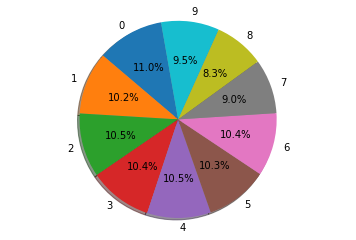

In [120]:
fig1, ax1 = plt.subplots()
ax1.pie(samp_counts, labels=samp_classes, autopct='%1.1f%%', shadow=True, startangle=100)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Now we will split the "new training" data again, in order to actually train our svm models

In [121]:
X_new = training_data_df[features]
y_new = training_data_df['Label']

In [122]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(X_new, y_new, random_state=3, test_size=.25)
print('new_X_train.shape = ', new_X_train.shape)
print('new_X_test.shape  = ', new_X_test.shape)
print('new_y_train.shape = ', new_y_train.shape)
print('new_y_test.shape  = ', new_y_test.shape)

new_X_train.shape =  (8409, 3072)
new_X_test.shape  =  (2803, 3072)
new_y_train.shape =  (8409,)
new_y_test.shape  =  (2803,)


#### Dismensionality reduction with 250 components

In [123]:
# Since we now have less images to work with, we can use more principal components to train our model with
# Creating a new PCA model
pca = PCA(n_components = 250)
X_train_pca = pca.fit_transform(new_X_train)
X_test_pca = pca.transform(new_X_test)
print(X_train_pca,'\n\n',X_train_pca.shape)
print('\n\n\n')
print(X_test_pca,'\n\n', X_test_pca.shape)

[[ 10.46085731  -2.27124002  11.84390636 ...  -0.66495209   1.06102369
   -1.97291515]
 [-25.94905708  -1.72697957 -18.48376549 ...  -0.76793553  -0.65502256
   -0.5181972 ]
 [-34.71026343  11.50696574  35.02186734 ...  -0.71192046   0.63731319
   -0.63370923]
 ...
 [-11.67666732  -8.16135682  -2.21184024 ...   0.06872363  -0.27550363
   -0.3673443 ]
 [ 50.06109562 -20.59561691   3.93953263 ...  -0.12486835  -0.26597946
   -1.86049185]
 [  8.26622462  17.57367762  -8.94880876 ...   0.11169799  -0.06601198
   -0.07942393]] 

 (8409, 250)




[[-16.59456046  -3.71226824  13.65562759 ...   0.17625667  -0.20379413
   -0.26742932]
 [-14.48564905   1.33576045  25.73687078 ...   0.71990786   0.52381153
   -0.60671434]
 [-17.68596682 -11.84823391  -9.81756979 ...  -1.34163324  -0.06147547
   -0.1381795 ]
 ...
 [ 26.31722696  32.07596265 -12.37549224 ...  -0.41151383   0.70736872
   -1.96817379]
 [ 43.55492408 -30.62478581   8.04070736 ...  -0.14007083  -0.93390284
   -0.9513875 ]
 [ -5.9808463

#### Creating SVC models

In [125]:
svm1 = SVC(C = 1, kernel = 'rbf', gamma = 0.0005, random_state = 1)
svm1.fit(X_train_pca, new_y_train)
y_preds1 = svm1.predict(X_test_pca)

In [127]:
acc = accuracy_score(new_y_test, y_preds1)
print('The accuracy score is', acc)

The accuracy score is 0.9900107028184089


##### Since the above model got .99 accuracy score using 250 compontents using only half of the labeled data, lets test how it does on the "unseen" labeled data

In [128]:
# X_test is the other half of the labeled data that we split in the first train/test split
X_test_pca = pca.fit_transform(X_test)

In [129]:
y_preds_test_1 = svm1.predict(X_test_pca)
print(y_preds_test_1)

[8 0 8 ... 0 7 4]


# Aha !

#### Note that when we used only half of the data to train the SVM model, then tested it on completely unseen data, we only achieved an accuracy of 43.02%. This proves that our models are clearly being overfit, and do not perform well with unseen data. This explains why we were constantly getting over 99% accuracy, yet the submissions we attempted were very poor

In [130]:
acc = accuracy_score(y_test, y_preds_test_1)
print('The accuracy score is', acc)

The accuracy score is 0.430164109882269
